# Advanced Structural Analysis and Dynamics 5
## Course Work 2 - Dynamics
2401456t - Mihail Todorov

# Submission requirements
## Report 
The report document should clearly and logically address all the tasks. 
Marks will be deducted for poor presentation. 
The report is to be submitted on-line via Moodle - hard-copies will not be marked.

You are to write the report using Google Colab / Jupyer notebook or similar software. 

You need to submit a single compressed file (zip or similar) containing:
* the *main_dynamics.ipynb* containing both the write up and code.
* the saved `npz` data files so that I can reproduce your results.
* A pdf print of the *main_dynamics.ipynb* containing the write up and code.

No other documents will be accepted.

Please make sure to use the `local_path` variable to set the path.
This will ensure that I can easily run your code on my computer. 

In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import math
import plotly as pl
import plotly.graph_objects as go
import seaborn
import pandas
import os
local_path = os.getcwd()

In [25]:
local_path
outfile = local_path + '\\data\\data_sheet'
outfile

'C:\\Users\\mi6or\\JUPYTER\\JUPYTER\\STRUCTURAL_ANALYSIS_5\\data\\data_sheet'

# Overview
In this report, you will use a finite element code written in Python for solving problems in elastodynamics. 
The code is an extension of the one you developed for a linear elastic bar in 1D.

You will not be required to develop any extensive code beyond that provided.

The report is to be uploaded to Moodle by the date specified on the Moodle. 

Late submissions will be penalised as per standard University policy. Please use the Q&A forum on Moodle to ask questions. 

Your answers to the questions should demonstrate your understanding of the theory covered in class.

# Problem statement
Consider a $L=20$ m long elastic rod fixed at $x=0$.
The cross-sectional area is 100 mm<sup>2</sup>.
The density (per unit volume) and the Young's modulus are $\tilde{\rho}=8000$ kg/m<sup>3</sup> and $E=200$ GPa, respectively.

A time-dependent natural boundary condition  $\overline{t}(t)$ is applied at $x=L$,  where

$
\begin{align*}
\overline{t}(t) = \overline{A}
\begin{cases}
 \sin(1000 \pi t) & \text{for } t \leq 0.001 \text{ s} \\
0										& \text{ otherwise}
\end{cases} \, ,
\end{align*}
$

where $\overline{A} = -4e^{4}$.

The time domain of interest is $[t_0=0,T=0.016]$ s.
The bar is approximated using 200 linear elements of equal length (unless stated otherwise).
Rayleigh (viscous) damping is to be ignored.

We denote by point A, the location $x=L/2$ - i.e. the midpoint of the rod.

## Exact solution
The following section shows you how to plot the exact solution for the stress evolution with time at point A. The variable `t_exact` and `stress_exact` are saved to the file `data_exact.npz`. 

Make sure you understand how to generate the exact solution as shown in the image below:

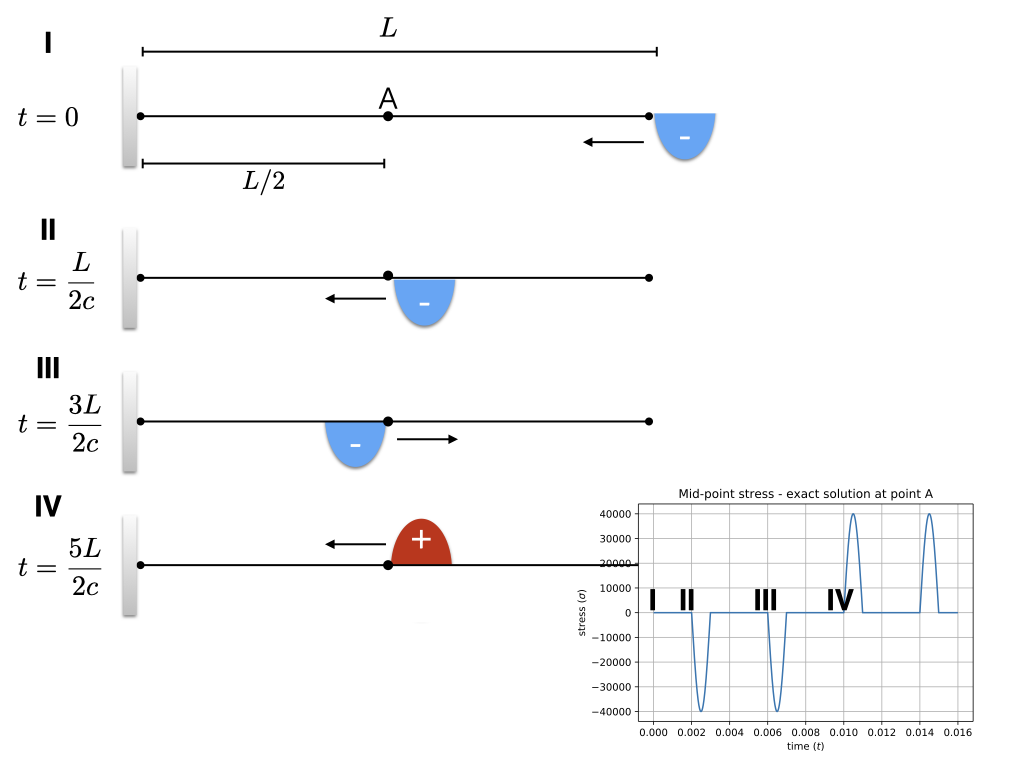

More information on saving and loading data files is provided below.

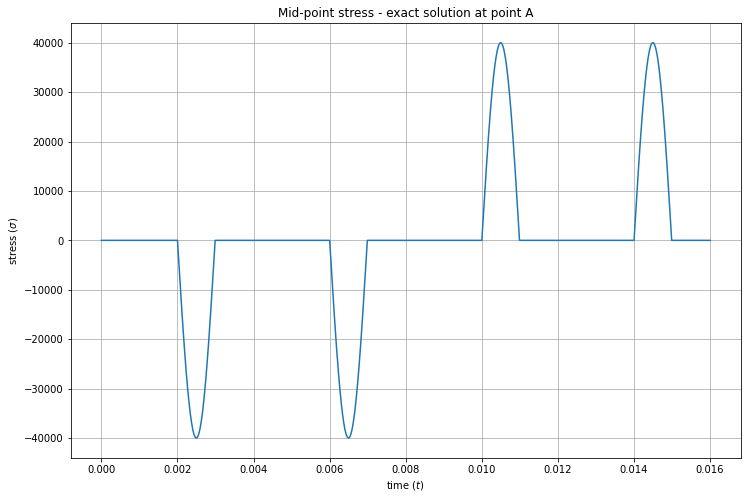

In [ ]:
T = 0.016
A_bar = -4e4
delta_t_exact = 1e-5
n_timestep_exact = int(T / delta_t_exact)
t_exact = np.linspace(0, T, n_timestep_exact + 1)
stress_exact = np.zeros((n_timestep_exact+1))
peak_steps = 100
peak_stress_dis = A_bar * np.sin(np.linspace(0, np.pi, peak_steps))

t_peak_1_beg = 200
t_peak_1_end = t_peak_1_beg + peak_steps
stress_exact[t_peak_1_beg:t_peak_1_end] = peak_stress_dis

t_peak_2_beg = 600
t_peak_2_end = t_peak_2_beg + peak_steps
stress_exact[t_peak_2_beg:t_peak_2_end] = peak_stress_dis

t_peak_3_beg = 1000
t_peak_3_end = t_peak_3_beg + peak_steps
stress_exact[t_peak_3_beg:t_peak_3_end] = -peak_stress_dis

t_peak_4_beg = 1400
t_peak_4_end = t_peak_4_beg + peak_steps
stress_exact[t_peak_4_beg:t_peak_4_end] = -peak_stress_dis

# selected output data is stored to a file with the name given below.
# use this to save the results from the simulations with different parameters
outfile = local_path + 'data/data_exact'
# here we save the stress data for the middle element.
# the data is saved to the file stored in the variable name `outfile`
np.savez(outfile, t_exact, stress_exact)

plt.figure(figsize = (12, 8))
plt.plot(t_exact,stress_exact)
plt.xlabel('time ($t$)')
plt.ylabel('stress ($\sigma$)')
plt.grid()
plt.title('Mid-point stress - exact solution at point A')
plt.show()

#Saving and loading data

The following code block shows you how to load saved data and to compare it to the exact solution. The files `data_LA.npz` and `data_FG.npz` contain the results of the simulations you have already performed and saved.

<pre><code>
npzfile_exact = np.load('data_exact.npz')
t_exact = npzfile_exact['arr_0']
stress_exact = npzfile_exact['arr_1']

npzfile_LA = np.load('data_LA.npz')
t_LA = npzfile_LA['arr_0']
stress_LA = npzfile_LA['arr_1']

npzfile_FG = np.load('data_FG.npz')
t_FG = npzfile_FG['arr_0']
stress_FG = npzfile_FG['arr_1']

line1, = plt.plot(t_exact,stress_exact, label = 'exact')
line2, = plt.plot(t_LA,stress_LA, label = 'LA')
line3, = plt.plot(t_FG,stress_FG, label = 'FG')
plt.xlabel('time ($t$)')
plt.ylabel('stress ($\sigma$)')
plt.title('Mid-point stress')
plt.legend(handles=[line1, line2, line3])
plt.grid()
plt.show()
</code></pre>

# Main function definitions

In [ ]:
def get_Ke(Ae, Ee, le):
  return  (Ae * Ee / le) * np.array([[1., -1.], [-1., 1.]])

def get_Me(Ae, rho_tilde_e, le, consistent):
  if consistent == True:
    return (Ae * rho_tilde_e * le / 6.) * np.array([[2., 1.], [1., 2.]])
  else:
    return (Ae * rho_tilde_e * le / 2.) * np.array([[1., 0.], [0., 1.]])

def get_dof_index(e):
  return [e, e + 1]   

def get_delta_t_crit(le, gamma, beta, consistent, c):
  term_A = gamma / 2. - beta
  if term_A < np.finfo(float).eps:
    return 1.0
  Omega_crit = term_A ** (-0.5)
  if consistent == True:
    omega_max = 2*np.sqrt(3)*c/le
  else:
    omega_max = 2*c/le
  return Omega_crit / omega_max 

# The finite element code
You are provided with the working finite element code shown below.

----------------------------------------------
beta = 0.167, 	gamma = 0.500
c = 5000.000
delta_t_crit =  2.000E-05, 	delta_t =  6.000E-06
delta_t / delta_t_crit = 0.300
----------------------------------------------
Time step:  200  , Total time:  0.0012000000000000001  of  0.016
Time step:  400  , Total time:  0.0024000000000000002  of  0.016
Time step:  600  , Total time:  0.0036  of  0.016
Time step:  800  , Total time:  0.0048000000000000004  of  0.016
Time step:  1000  , Total time:  0.006  of  0.016
Time step:  1200  , Total time:  0.0072  of  0.016
Time step:  1400  , Total time:  0.0084  of  0.016
Time step:  1600  , Total time:  0.009600000000000001  of  0.016
Time step:  1800  , Total time:  0.0108  of  0.016
Time step:  2000  , Total time:  0.012  of  0.016
Time step:  2200  , Total time:  0.0132  of  0.016
Time step:  2400  , Total time:  0.0144  of  0.016
Time step:  2600  , Total time:  0.015600000000000001  of  0.016


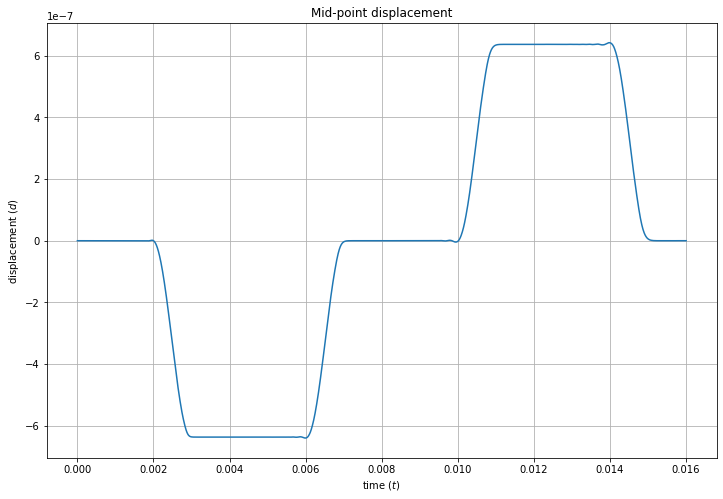

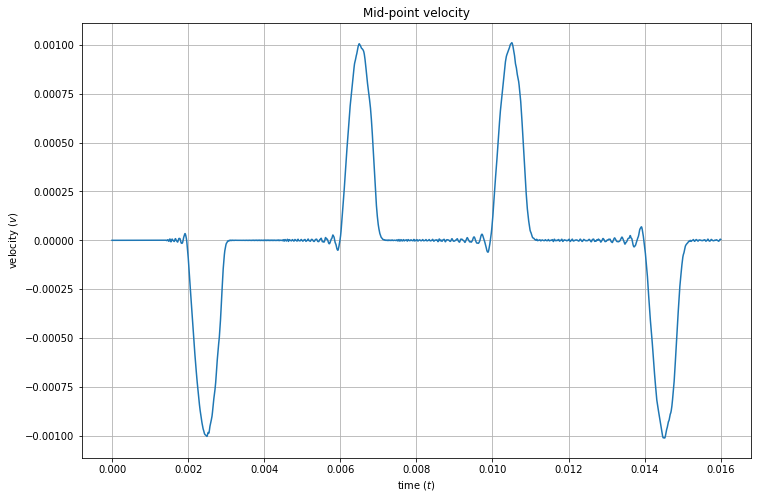

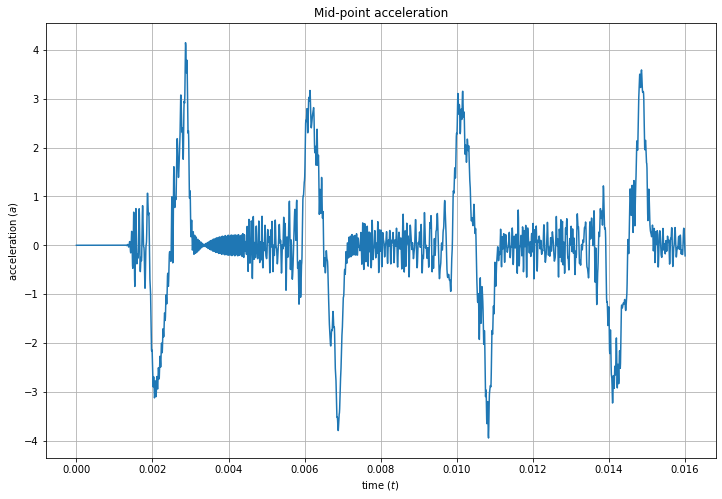

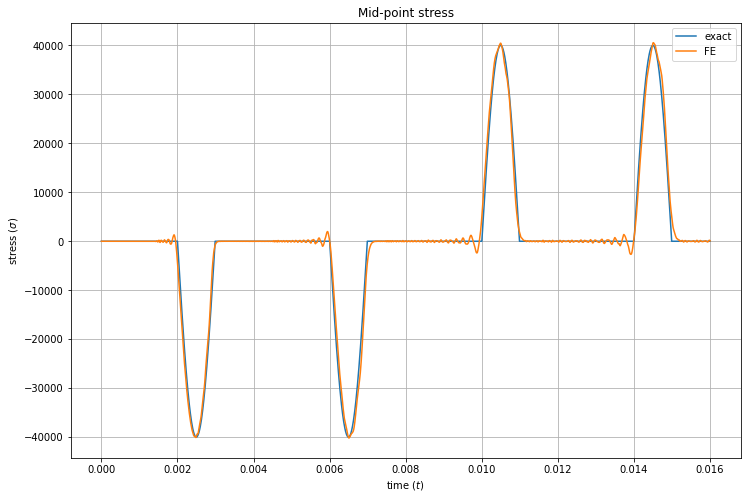

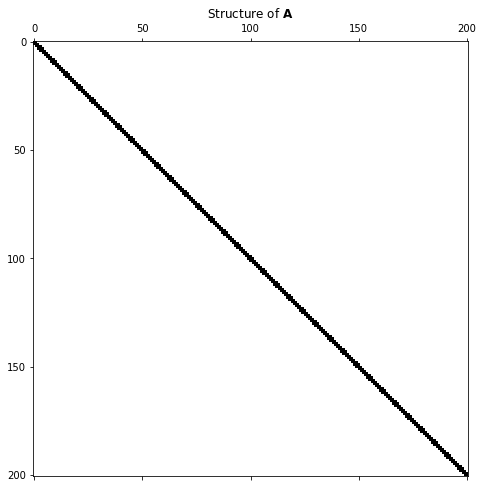

In [ ]:
# material properties
E = 200e9         # Young's modulus [N/m**2]
rho_tilde = 8000  # density [kg/m**3]

multimat = False  # flag for multimaterials 

# domain data
L = 20.       # length of the domain [m]
Ae = 100e-6   # cross sectional area [m**2]

# loading 
A_bar = -4e4  # applied traction [N/m**2]

# mesh data
n_el = 200                # number of elements
n_np = n_el + 1           # number of nodal points
n_dof = n_np              # number of degrees of freedom
x = np.linspace(0, L, n_np) # x-coordinates of the nodes
le = L / n_el             # length of an element

# time integration data
# see note for further details
# Newmark method parameters
#  Scheme |    beta    |   gamma  
#   AA*   |    1/4     |   1/2    
#   LA    |    1/6     |   1/2
#   FG    |    1/12    |   1/2
#   CD    |    0       |   1/2   
# note the AA scheme is unconditionally stable.
# Newmark parameters
beta = 1./6
gamma = 1./2
consistent = True   # use a consistent mass matrix

T = 0.016   # total time
c = np.sqrt(E/ rho_tilde)  # wave speed

# compute the critical time-step
# note: uncondionally stable AA scheme will return 1.0
delta_t_crit = get_delta_t_crit(le, gamma, beta , consistent, c)


# actual times-step used is a factor of the critical time-step
reduction_factor = 0.3
delta_t = reduction_factor * delta_t_crit

# selected output data is stored to a file with the name given below
# use this to save the results from the different runs
# change the name to match the data you want to store
outfile = local_path + 'data/data_LA_0_3_mass_con.npz'


print('----------------------------------------------')
print('beta = %2.3f, \tgamma = %2.3f' %(beta, gamma))
print('c = %2.3f' %c)
print('delta_t_crit = %10.3E, \tdelta_t = %10.3E' %(delta_t_crit, delta_t))
print('delta_t / delta_t_crit = %2.3f' %(reduction_factor))
print('----------------------------------------------')

n_t_steps = int(np.ceil(T / delta_t));    # number of time step

# initialise the time domain, K and M
t = np.linspace(0, T, n_t_steps)
K = np.zeros((n_dof, n_dof))
M = np.zeros((n_dof, n_dof))

# assemble K and M
for ee in range(n_el):
  dof_index = get_dof_index(ee)

  K[np.ix_(dof_index, dof_index)] +=  get_Ke(Ae, E, le)
  M[np.ix_(dof_index, dof_index)] +=  get_Me(Ae, rho_tilde, le, consistent)

# damping matrix
C = np.zeros((n_dof, n_dof))

# assemble the system matrix A
A_matrix = M + (gamma * delta_t) * C + (beta * delta_t**2)*K 

# define the free dofs
free_dof = np.arange(1,n_dof)

# initial conditions
d = np.zeros((n_dof, 1))
v = np.zeros((n_dof, 1))
F = np.zeros((n_dof, 1))

# compute the initial acceleration
a = np.linalg.solve(M, F - C.dot(v) - K.dot(d))

# store the history data 
# rows -> each node 
# columns -> each time step including initial at 0
d_his = np.zeros((n_dof, n_t_steps))
v_his = np.zeros((n_dof, n_t_steps))
a_his = np.zeros((n_dof, n_t_steps))
d_his[:,0] = d[:,0]
v_his[:,0] = v[:,0]
a_his[:,0] = a[:,0]

# loop over the time domain and solve the problem at each step
for n in range(1,n_t_steps):
  if n % 200 == 0:
    print('Time step: ', n, ' , Total time: ', n*delta_t, ' of ', T)
  
  # data at beginning of the time-step n
  a_n = a
  v_n = v
  d_n = d

  # applied loading
  t_current = n * delta_t # current time
  if t_current<0.001:
    F[-1] = A_bar * Ae * np.sin(1000 * t_current * np.pi)
  else:
    F[-1]=0.
    
  # define predictors
  d_tilde = d_n + delta_t*v_n + ((delta_t**2)/2.) * (1 - 2*beta) * a_n
  v_tilde = v_n + (1 - gamma) * delta_t * a_n
    
  # assemble the right-hand side from the known data
  R = F - C.dot(v_tilde) - K.dot(d_tilde)
    
  # impose essential boundary condition and solve A a = RHS
  A_free = A_matrix[np.ix_(free_dof, free_dof)]
  R_free = R[np.ix_(free_dof)]

  # solve for the accelerations at the free nodes
  a_free = np.linalg.solve(A_free, R_free) 
  a = np.zeros((n_dof, 1))
  a[1:] = a_free
    
  # update displacement and vecloity predictors using the acceleration
  d = d_tilde + (beta * delta_t**2) * a
  v = v_tilde + (gamma * delta_t) * a
    
  # store solutions
  d_his[:,n] = d[:,0]
  v_his[:,n] = v[:,0]
  a_his[:,n] = a[:,0]

# post-processing
mid_node = int(np.ceil(n_dof / 2))  # mid node

# compute the stress in each element
# assuming constant E
stress = (E / le) * np.diff(d_his, axis=0)

# here we save the stress data for the middle element
np.savez(outfile, t, stress[mid_node,:])

plt.figure(figsize = (12, 8))
plt.plot(t,d_his[mid_node,:])
plt.xlabel('time ($t$)')
plt.ylabel('displacement ($d$)')
plt.title('Mid-point displacement')
plt.grid()
plt.show()

plt.figure(figsize = (12, 8))
plt.plot(t,v_his[mid_node,:])
plt.xlabel('time ($t$)')
plt.ylabel('velocity ($v$)')
plt.title('Mid-point velocity')
plt.grid()
plt.show()

plt.figure(figsize = (12, 8))
plt.plot(t,a_his[mid_node,:])
plt.xlabel('time ($t$)')
plt.ylabel('acceleration ($a$)')
plt.title('Mid-point acceleration')
plt.grid()
plt.show()

# plot the exact stress versus the FE predicted stress
plt.figure(figsize = (12, 8))
line1, = plt.plot(t_exact,stress_exact, label = 'exact')
line2, = plt.plot(t,stress[mid_node,:], label = 'FE')
plt.xlabel('time ($t$)')
plt.ylabel('stress ($\sigma$)')
plt.title('Mid-point stress')
plt.legend(handles=[line1, line2])
plt.grid()
plt.show()

plt.figure(figsize = (12, 8))
plt.spy(A_matrix)
plt.title('Structure of $\mathbf{A}$')
plt.show()   

# Question 1
* What is the bar wave velocity $c$?
* How long will it take for a disturbance applied at the free end to travel the length of the bar?
* How is this behaviour different to that of the linear elastic problem (i.e. with no inertial term present) considered previously in this course?

# Question 2
Assume a consistent mass matrix. Use the critical time-step size as computed by the central difference method.

For  ratios of $\Delta t / \Delta t_\text{c} = 0.1,~0.9,~0.99,~1,~1.1,~ 2$, compare the stress response at point A for the average acceleration and central difference schemes.
Also show the exact solution in your results.

Explain the results with reference to the theory discussed in the lectures.

# Question 3
Plot the stress history at point A for the average acceleration scheme and compare it to the solution obtained using  $(\beta = 1/4, \gamma = 0.51)$, $(\beta = 1/4, \gamma = 0.55)$, and $(\beta = 1/4, \gamma = 0.85)$.
Superimpose the exact solution on your plots.

For the average acceleration scheme use $\Delta t = 0.9 t_c$ where the critical time-step is computed using the central difference scheme. 
For the other schemes also use a factor of 0.9 of the respective critical time-step. 

Explain the results with reference to the theory discussed during the lectures.

# Question 4
Assume a  $\Delta t  / \Delta t_\text{c} = 0.75$.
Plot the stress history at point A for the central difference scheme for both a consistent mass matrix and a lumped mass matrix.

Superimpose the exact solution on your plots.

Comment on the structure of the matrix $\mathbf{A}$.
Comment on the results.

# Question 5
Now consider a bar where the Young's modulus $E=200$ GPa for $0 \leq x \leq 0.25 L$ and $E=400$ GPa for $0.25 L < x \leq L$.
Assume a lumped mass matrix and use the Fox Goodwin scheme.

What is the critical time step size?

For a stable time-step choice, plot the stress history at point A and try to explain your results. 